## GEI723 — Automne 2025
### Neurosciences computationnelles et applications en traitement de l'information

Contenu créé par Ismael Balafrej, Ph.D., Jean Rouat, Ph.D. et Ahmad El Ferdaoussi, Ph.D.

Ce notebook est une adaptation de la classification par STDP de MNIST par Diehl & Cook. L'article de Diehl & Cook est disponible ici: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

Le modèle est simplifié un peu et réécrit pour Brian2 et Python 3. Le code est à trous, et les parties à compléter sont indiquées par 'COMPLETER'.

ATTENTION: Dans l'exemple donné ici les auteurs utilisent seulement des données d'entrainement et de validation. Ils utilisent à tort le mot "test" pour désigner les données de validation.

Les équations et certains paramètres des neurones sont fournies.

Un exemple d'encodage par fréquence est utilisé (voir la partie "testons à présent le réseau entrainé'). Vous avez toute liberté d'utiliser un autre type d'encodage.

### Différences avec les travaux de Diehl et Cook et avec l'article
La solution python (Brian1) présentée à l'origine sur le github des auteurs de l'article ne reflète pas exactement les équations de l'article. Nous avons par ailleurs converti en Brian 2 une partie de ce code tout en ajoutant certains éléments qui ne sont pas toujours dans l'article (comme par exemple les connexions avec probabilité). À noter qu'une autre version traduite en Brian 2 existe sur le github: https://github.com/zxzhijia/Brian2STDPMNIST .
SVP ne tombez pas dans le piège de vouloir absolument reproduire de façon parfaite ces codes informatiques. Ce serait une perte de temps car vous serez interrogé sur votre compréhension de la matière. Passer beaucoup de temps à vouloir remplir un code à trous de façon parfaite ne serait pas intéressant si cette démarche ne vous permet pas de comprendre.

Méthode de travail recommandée:
- Inplémenter dans un premier temps votre solution selon la compréhension de l'article que vous avez sans vouloir "coller" exactement au code à trous. Ceci vous permettra de comprendre l'algorithme de STDP. Dans ce contexte, le code à trous (et les codes disponibles sur internet) sont des éléments pour améliorer votre compréhension et déverminer votre code et non pas pour les "copier" tels qu'ils sont.
- Ensuite seulement, vous pourrez inclure les variantes proposées dans l'article et/ou dans les codes d'exemples.

### Voici les différences et éléments principaux:
Le code vous laisse le choix:
 - de la façon d'initialiser les poids du réseau (vous pouvez ainsi comparer l'impact d'une initialisation aléatoire versus une fixe);
 - de la façon de présenter les entrées au réseau avec possibilité d'introduire des délais (aléatoires ou fixes) sur les neurones d'entrée;
 - de normaliser les poids (qui est différente de celle présentée à l'équation (3) de l'article). À noter que dans l'article, les auteurs disent avoir utilisé la normalisation divisive des poids selon les travaux de Goodhill et Barrow.
 - Créer des connexions avec une probabilité donnée, ce qui peut être utile pour la recherche de réseaux ayant le moins de paramètres possibles à stocker.
 - Possibilité de choisir le temps de présentation des données.
 - etc.

#### ATTENTION: Ce code est fourni à titre d'exemple. Vous n'avez aucune obligation de résoudre votre problème spécifiquement avec ce code.

In [26]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline

## Ensemble de données MNIST

On télécharge l'ensemble de données MNIST directement dans le code. MNIST est disponible à https://www.openml.org/d/554

L'argument 'data_home' peut être utilisé pour télécharger MNIST dans un répertoire de votre choix. (Le répertoire par défaut est '~/scikit_learn_data/'.)

In [27]:
X_all, y_all = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home="data")

MNIST est constituté de 70k d'images de 28x28 pixels, de chiffres.

'X' est le vecteur d'images, et 'y' est le vecteur d'étiquettes (labels).

In [28]:
X_all.shape, y_all.shape

((70000, 784), (70000,))

La simulation avec toutes les images est assez longue à faire rouler. Utilisons uniquement un sous-ensemble de MNIST pour une simulation plus rapide.

In [29]:
X = X_all[:1000]
y = y_all[:1000]

Divisons MNIST en ensembles d'entrainement et de test pour entrainer et tester le modèle post-apprentissage.

Si on travaille avec l'ensemble au complet, on peut prendre 10k pour le test par exemple.

In [30]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=100)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

Dessinons une image aléatoire de l'ensemble de données pour voir ce à quoi ressemble MNIST.

Les images dans MNIST sont des vecteurs. Il faut donc les ré-organiser en matrice 28x28 pour les afficher.

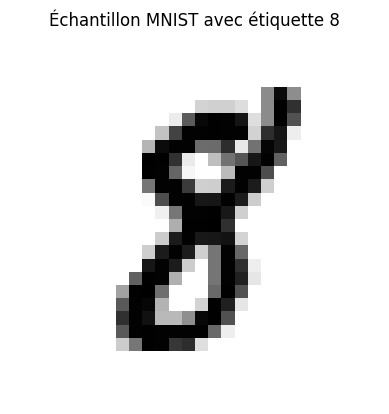

In [31]:
index = np.random.randint(0, len(X_train)-1)

plt.figure()
plt.axis('off')
plt.imshow(X_train[index].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title("Échantillon MNIST avec étiquette %s" % y_train[index]);

## Réseau de neurones Brian2

On peut maintenant créer un réseau Brian2. Commençons par définir quelques paramètres.

In [32]:
# Fixons le seed aléatoire afin de pouvoir reproduire les résultats
np.random.seed(0)

# Horloge de Brian2
defaultclock.dt = 1 * units.ms

# Cible de génération de code pour Brian2
prefs.codegen.target = 'cython'

time_per_sample =   0.35 * units.second
resting_time = 0.15 * units.second

v_rest_e = -65. * units.mV
v_rest_i = -60. * units.mV

v_reset_e = -65. * units.mV
v_reset_i = -45. * units.mV

v_thresh_e = -52. * units.mV
v_thresh_i = -40. * units.mV

refrac_e = 5. * units.ms
refrac_i = 2. * units.ms

tc_theta = 1e5 * units.ms
theta_plus_e = 0.05 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms
tc_post_2_ee = 40 * units.ms

# Taux d'apprentissage
nu_ee_pre =  0.001
nu_ee_post = 0.01

Définissons l'entrée au réseau de neurones. L'entrée est un encodeur de type codage par fréquence (rate coding).

In [33]:
input_group = PoissonGroup(784, rates=64*Hz)

Définissons notre modèle de neurone ainsi que nos groupes de neurones.

In [34]:
neuron_model = '''
    dv/dt = ((v_rest_e - v) + (I_synE + I_synI) / nS) / tau  : volt (unless refractory)

    I_synE =  ge * nS * -v           : amp
    
    I_synI =  gi * nS * (d_I_synI-v) : amp
    
    dge/dt = -ge/(1.0*ms)            : 1
    
    dgi/dt = -gi/(2.0*ms)            : 1
    
    tau                              : second (constant, shared)
    
    d_I_synI                         : volt (constant, shared)
    
    dtheta/dt = -theta / (tc_theta)  : volt
'''

excitatory_group = NeuronGroup(
    N=400, model=neuron_model, refractory=refrac_e,
    threshold='v > v_thresh_e + theta', reset='v=v_reset_e; theta += theta_plus_e', method='euler')
excitatory_group.tau = 100 * units.ms
excitatory_group.d_I_synI = -100. * units.mV

inhibitory_group = NeuronGroup(
    N=400, model=neuron_model, refractory=refrac_i,
    threshold='v > v_thresh_i', reset='v=v_reset_i', method='euler')
inhibitory_group.tau = 10 * units.ms
inhibitory_group.d_I_synI = -85. * mV

Et les synapses.

In [35]:
synapse_model = "w : 1"

stdp_synapse_model = '''
    w : 1

    plastic : boolean (shared) # Activer/désactiver la plasticité
    
    post2before : 1
    
    dpre/dt   =   -pre / tc_pre_ee : 1 (event-driven)
    
    dpost1/dt  = -post1 / tc_post_1_ee : 1 (event-driven)
    
    dpost2/dt = -post2 / tc_post_2_ee : 1 (event-driven)
'''

stdp_pre = '''
    ge_post += w
    
    pre = 1.
    
    w = clip(w + (nu_ee_pre * post1) * int(plastic), 0, 1)
'''

stdp_post = '''
    post2before = post2
    
    w = clip(w + (nu_ee_post * pre * post2before) * int(plastic), 0, 1)
    
    post1 = 1.
    
    post2 = 1.
'''

input_synapse = Synapses(input_group, excitatory_group, model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post)
input_synapse.connect(True) # Fully connected
input_synapse.delay = 'clip(5*ms + randn()*2*ms, 0.5*ms, 15*ms)'
input_synapse.plastic = True
# Xavier/Glorot-like initialization for SNNs
n_in = 784
n_out = 100
w_max = 0.5
input_synapse.w = f'rand() * {w_max * np.sqrt(2.0 / (n_in + n_out))}'

e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=synapse_model, on_pre='ge_post += w')
e_i_synapse.connect(j='i')
e_i_synapse.w = 'rand()*10.4'

i_e_synapse = Synapses(inhibitory_group, excitatory_group, model=synapse_model, on_pre='gi_post += w')
i_e_synapse.connect(p=0.7, condition='i != j')
i_e_synapse.w = 'rand()*12.0'

WARNING    'i' is an internal variable of group 'synapses_4', but also exists in the run namespace with the value 399. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_5', but also exists in the run namespace with the value 399. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Combien de synapses a-t-on dans le réseau?

In [36]:
print(len(input_synapse) + len(e_i_synapse) + len(i_e_synapse))

425504


Définissons un 'readout' pour notre réseau.

In [37]:
e_monitor = SpikeMonitor(excitatory_group, record=True)

Créons le réseau.

In [38]:
net = Network(input_group, excitatory_group, inhibitory_group,
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

## Entrainement

Entrainons à présent notre réseau.

Créons une matrice 'spikes' pour assigner les étiquettes des classes post-apprentissage. Cette matrice accumulera le décompte de décharges par classe.

Notre readout 'e_monitor' est actif tout le long de la simulation avec toutes les images. Donc à chaque nouvelle présentation d'image, on doit soustraire l'ancien décompte de décharges. On utilisera le vecteur 'old_spike_counts' pour le faire.

In [39]:
spikes = np.zeros((10, len(excitatory_group)))
old_spike_counts = np.zeros(len(excitatory_group))


In [75]:
number_of_epochs = 10

for epoch in range(number_of_epochs):  # Fixed: renamed from i to epoch
    print('Starting iteration %i' % epoch)
    for sample_idx, (sample, label) in enumerate(zip(X_train, y_train)):  # Fixed: renamed from j to sample_idx
        # Afficher régulièrement l'état d'avancement
        if (sample_idx % 10) == 0:
            print("Running sample %i out of %i" % (sample_idx, len(X_train)))

        # Configurer le taux d'entrée
        input_group.rates = sample / 4 * units.Hz

        # Simuler le réseau
        net.run(time_per_sample)

        # Enregistrer les décharges
        spikes[int(label)] += e_monitor.count - old_spike_counts
        # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
        old_spike_counts = np.copy(e_monitor.count)

        # Arrêter l'entrée
        input_group.rates = 0 * units.Hz

        # Laisser les variables retourner à leurs valeurs de repos
        net.run(resting_time)

        # Normaliser les poids
        if sample_idx % 10 == 0:
            weight_matrix = np.zeros((len(input_group), len(excitatory_group)))
            weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
            colSums = np.sum(weight_matrix, axis=0)
            colFactors = 78.4 / colSums
            for neuron_idx in range(len(excitatory_group)):
                weight_matrix[:, neuron_idx] *= colFactors[neuron_idx]
            input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]

Starting iteration 0
Running sample 0 out of 900
Running sample 10 out of 900


KeyboardInterrupt: 

## Test

Commençons par trouver le meilleur neurone pour chaque classe de MNIST.

In [41]:
neuron_assignments = np.argmax(spikes, axis=0)
print("Neuron assignments:", neuron_assignments)

Neuron assignments: [7 0 3 3 0 0 0 1 8 9 0 1 3 7 3 0 4 0 0 5 0 3 0 1 0 3 7 1 2 7 0 4 1 0 3 6 0
 3 0 6 1 6 0 6 2 6 0 9 0 1 7 2 6 4 7 4 6 4 0 0 6 4 7 0 3 7 0 7 2 4 3 9 0 2
 6 3 0 0 0 1 7 3 0 2 6 7 2 9 4 0 1 7 7 8 8 2 0 1 0 0 0 4 7 1 8 7 6 5 7 0 0
 0 0 4 9 0 0 7 4 1 0 8 0 3 7 2 7 0 3 0 1 6 3 8 9 0 1 0 2 9 0 0 6 7 2 3 9 1
 0 0 0 4 7 7 0 9 0 6 3 3 0 9 3 4 3 1 0 6 0 7 2 6 7 9 0 1 6 1 2 4 0 0 7 3 7
 4 7 5 3 2 0 3 2 8 2 2 2 0 7 3 3 3 0 0 7 3 7 0 0 4 0 0 7 0 0 6 1 3 2 4 2 7
 0 4 3 1 2 3 0 3 6 1 3 3 7 7 3 2 0 1 2 2 6 0 0 2 2 3 9 0 1 4 7 4 6 7 1 0 0
 0 3 2 0 4 0 3 3 2 0 0 6 7 8 4 3 0 4 7 6 3 7 3 4 4 8 4 3 0 7 0 0 4 3 8 7 0
 0 0 8 0 1 9 6 0 1 8 0 2 9 7 5 4 2 3 2 0 0 3 1 0 0 4 0 0 0 8 3 4 3 8 8 9 3
 0 6 7 9 2 0 0 1 0 8 6 3 2 0 3 5 7 8 7 3 0 0 2 7 8 4 7 0 0 4 0 0 7 0 7 7 3
 0 0 0 2 0 0 0 3 2 1 2 8 0 0 9 0 2 0 0 9 2 0 0 0 0 8 8 0 0 6]


Testons à présent le réseau entrainé!

In [42]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False

num_correct_output = 0
old_spike_counts = np.zeros(len(excitatory_group))

for i, (sample, label) in enumerate(zip(X_test, y_test)):
    # Afficher régulièrement l'état d'avancement
    if (i % 10) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))

    excitatory_group.theta = 0 * units.mV

    # Configurer le taux d'entrée
    # ATTENTION, vous pouvez utiliser un autre type d'encodage
    input_group.rates = sample / 4 * units.Hz

    # Simuler le réseau
    net.run(time_per_sample)

    # Calculer le nombre de décharges pour l'échantillon
    current_spike_count = e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)

    digit_spikes = np.zeros(10)
    for neuron_idx in range(len(excitatory_group)):
        digit_spikes[neuron_assignments[neuron_idx]] += current_spike_count[neuron_idx]

    output_label = np.argmax(digit_spikes)

    # Si la prédiction est correcte
    if output_label == int(label):
        num_correct_output += 1

    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)


print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))

Running sample 0 out of 100
Running sample 10 out of 100
Running sample 20 out of 100
Running sample 30 out of 100
Running sample 40 out of 100
Running sample 50 out of 100
Running sample 60 out of 100
Running sample 70 out of 100
Running sample 80 out of 100
Running sample 90 out of 100
The model accuracy is : 0.380


In [43]:
import pickle
import numpy as np

model_data = {
    'weights': np.array(input_synapse.w),
    'weight_indices_i': np.array(input_synapse.i),
    'weight_indices_j': np.array(input_synapse.j),
    'theta': np.array(excitatory_group.theta),
    'labeled_neurons': neuron_assignments,
    'spikes': spikes,
    'num_excitatory': len(excitatory_group),
}

with open('stdp_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print("✓ Modèle sauvegardé!")

✓ Modèle sauvegardé!


In [95]:
import pickle
import numpy as np

with open('stdp_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

# Après avoir recréé le réseau:
input_synapse.w = model_data['weights']
excitatory_group.theta = model_data['theta']* units.mV
labeled_neurons = model_data['labeled_neurons']
spikes = model_data['spikes']
print("✓ Modèle chargé!")

✓ Modèle chargé!


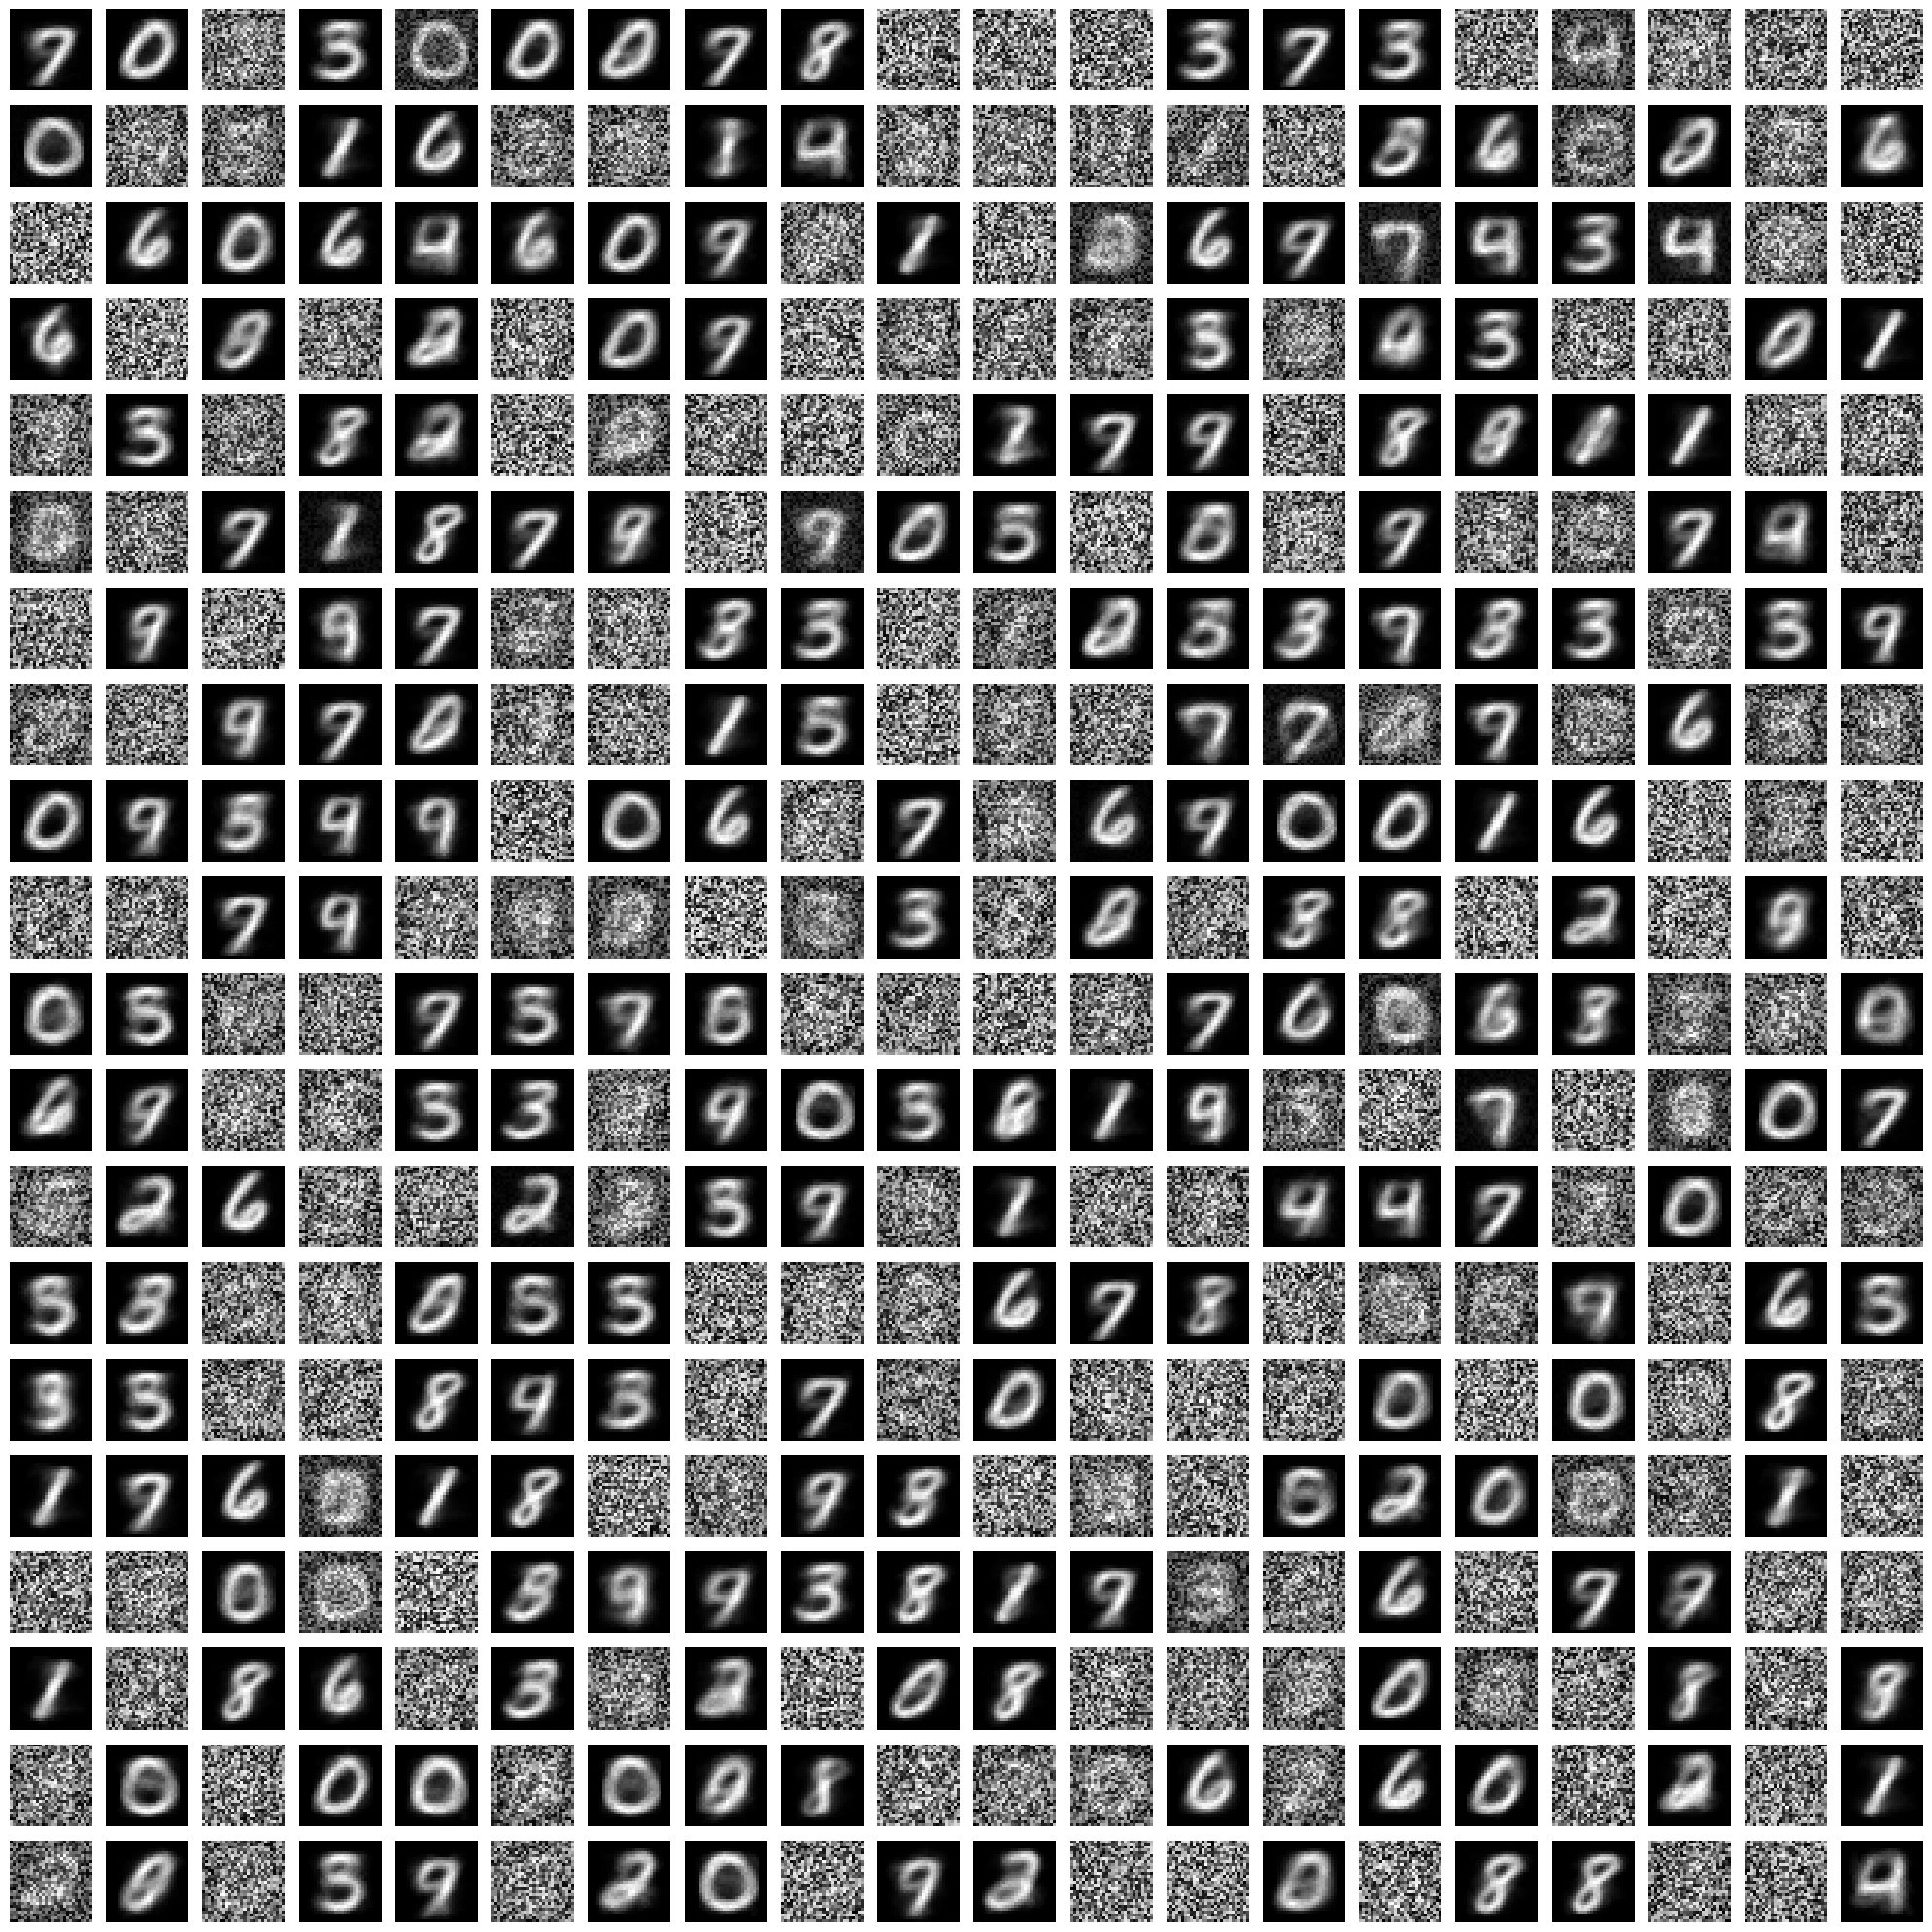

In [96]:
# 1. Visualiser les poids
weight_matrix = np.zeros((784, len(excitatory_group)))
weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w

plt.figure(figsize=(20, 20))  # Larger figure for more neurons
for i in range(min(400, len(excitatory_group))):  # Changed from 100 to 400
    plt.subplot(20, 20, i+1)  # Changed from 10x10 to 20x20 grid
    plt.imshow(weight_matrix[:, i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [55]:
from collections import Counter
counts = Counter(neuron_assignments)
for digit in range(10):
    print(f"Chiffre {digit}: {counts.get(digit, 0)} neurones")

Chiffre 0: 126 neurones
Chiffre 1: 29 neurones
Chiffre 2: 39 neurones
Chiffre 3: 53 neurones
Chiffre 4: 32 neurones
Chiffre 5: 5 neurones
Chiffre 6: 27 neurones
Chiffre 7: 50 neurones
Chiffre 8: 21 neurones
Chiffre 9: 18 neurones


In [47]:
print(spikes.sum(axis=1))

[165766. 102589. 143990. 139004. 122531. 123821. 130898. 148177. 129880.
 137792.]


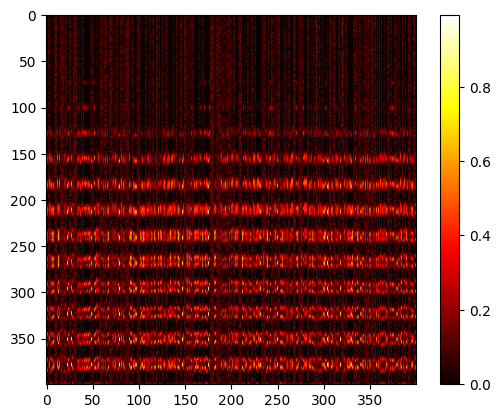

In [48]:
plt.imshow(weight_matrix[:400, :400], cmap='hot')
plt.colorbar()
plt.show()

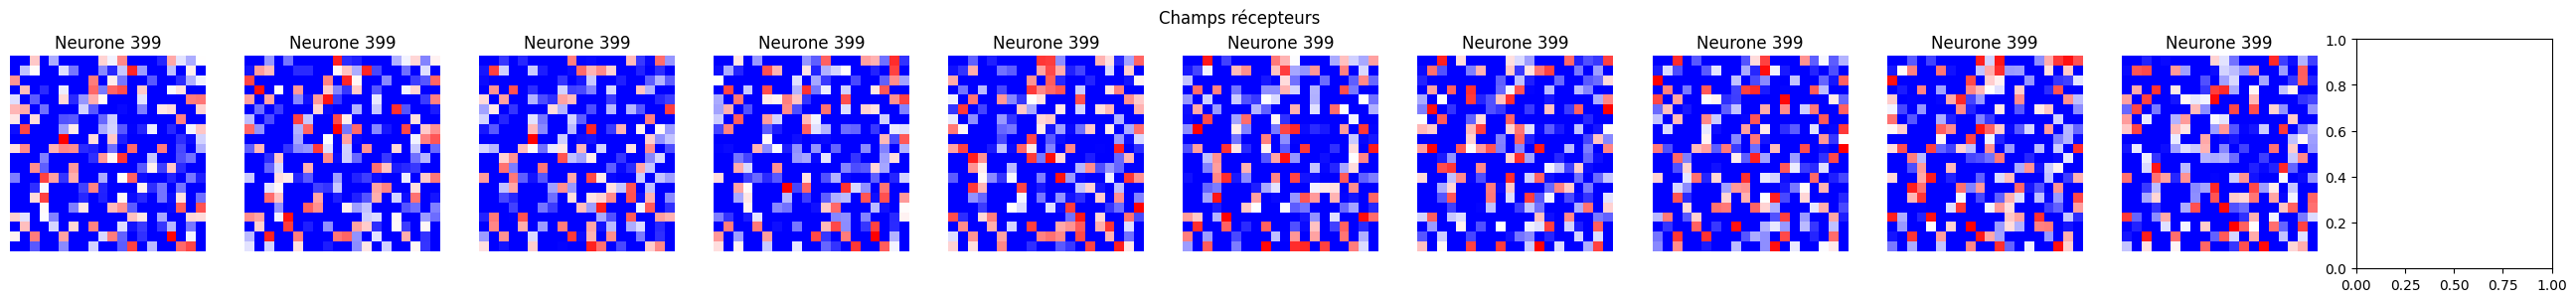

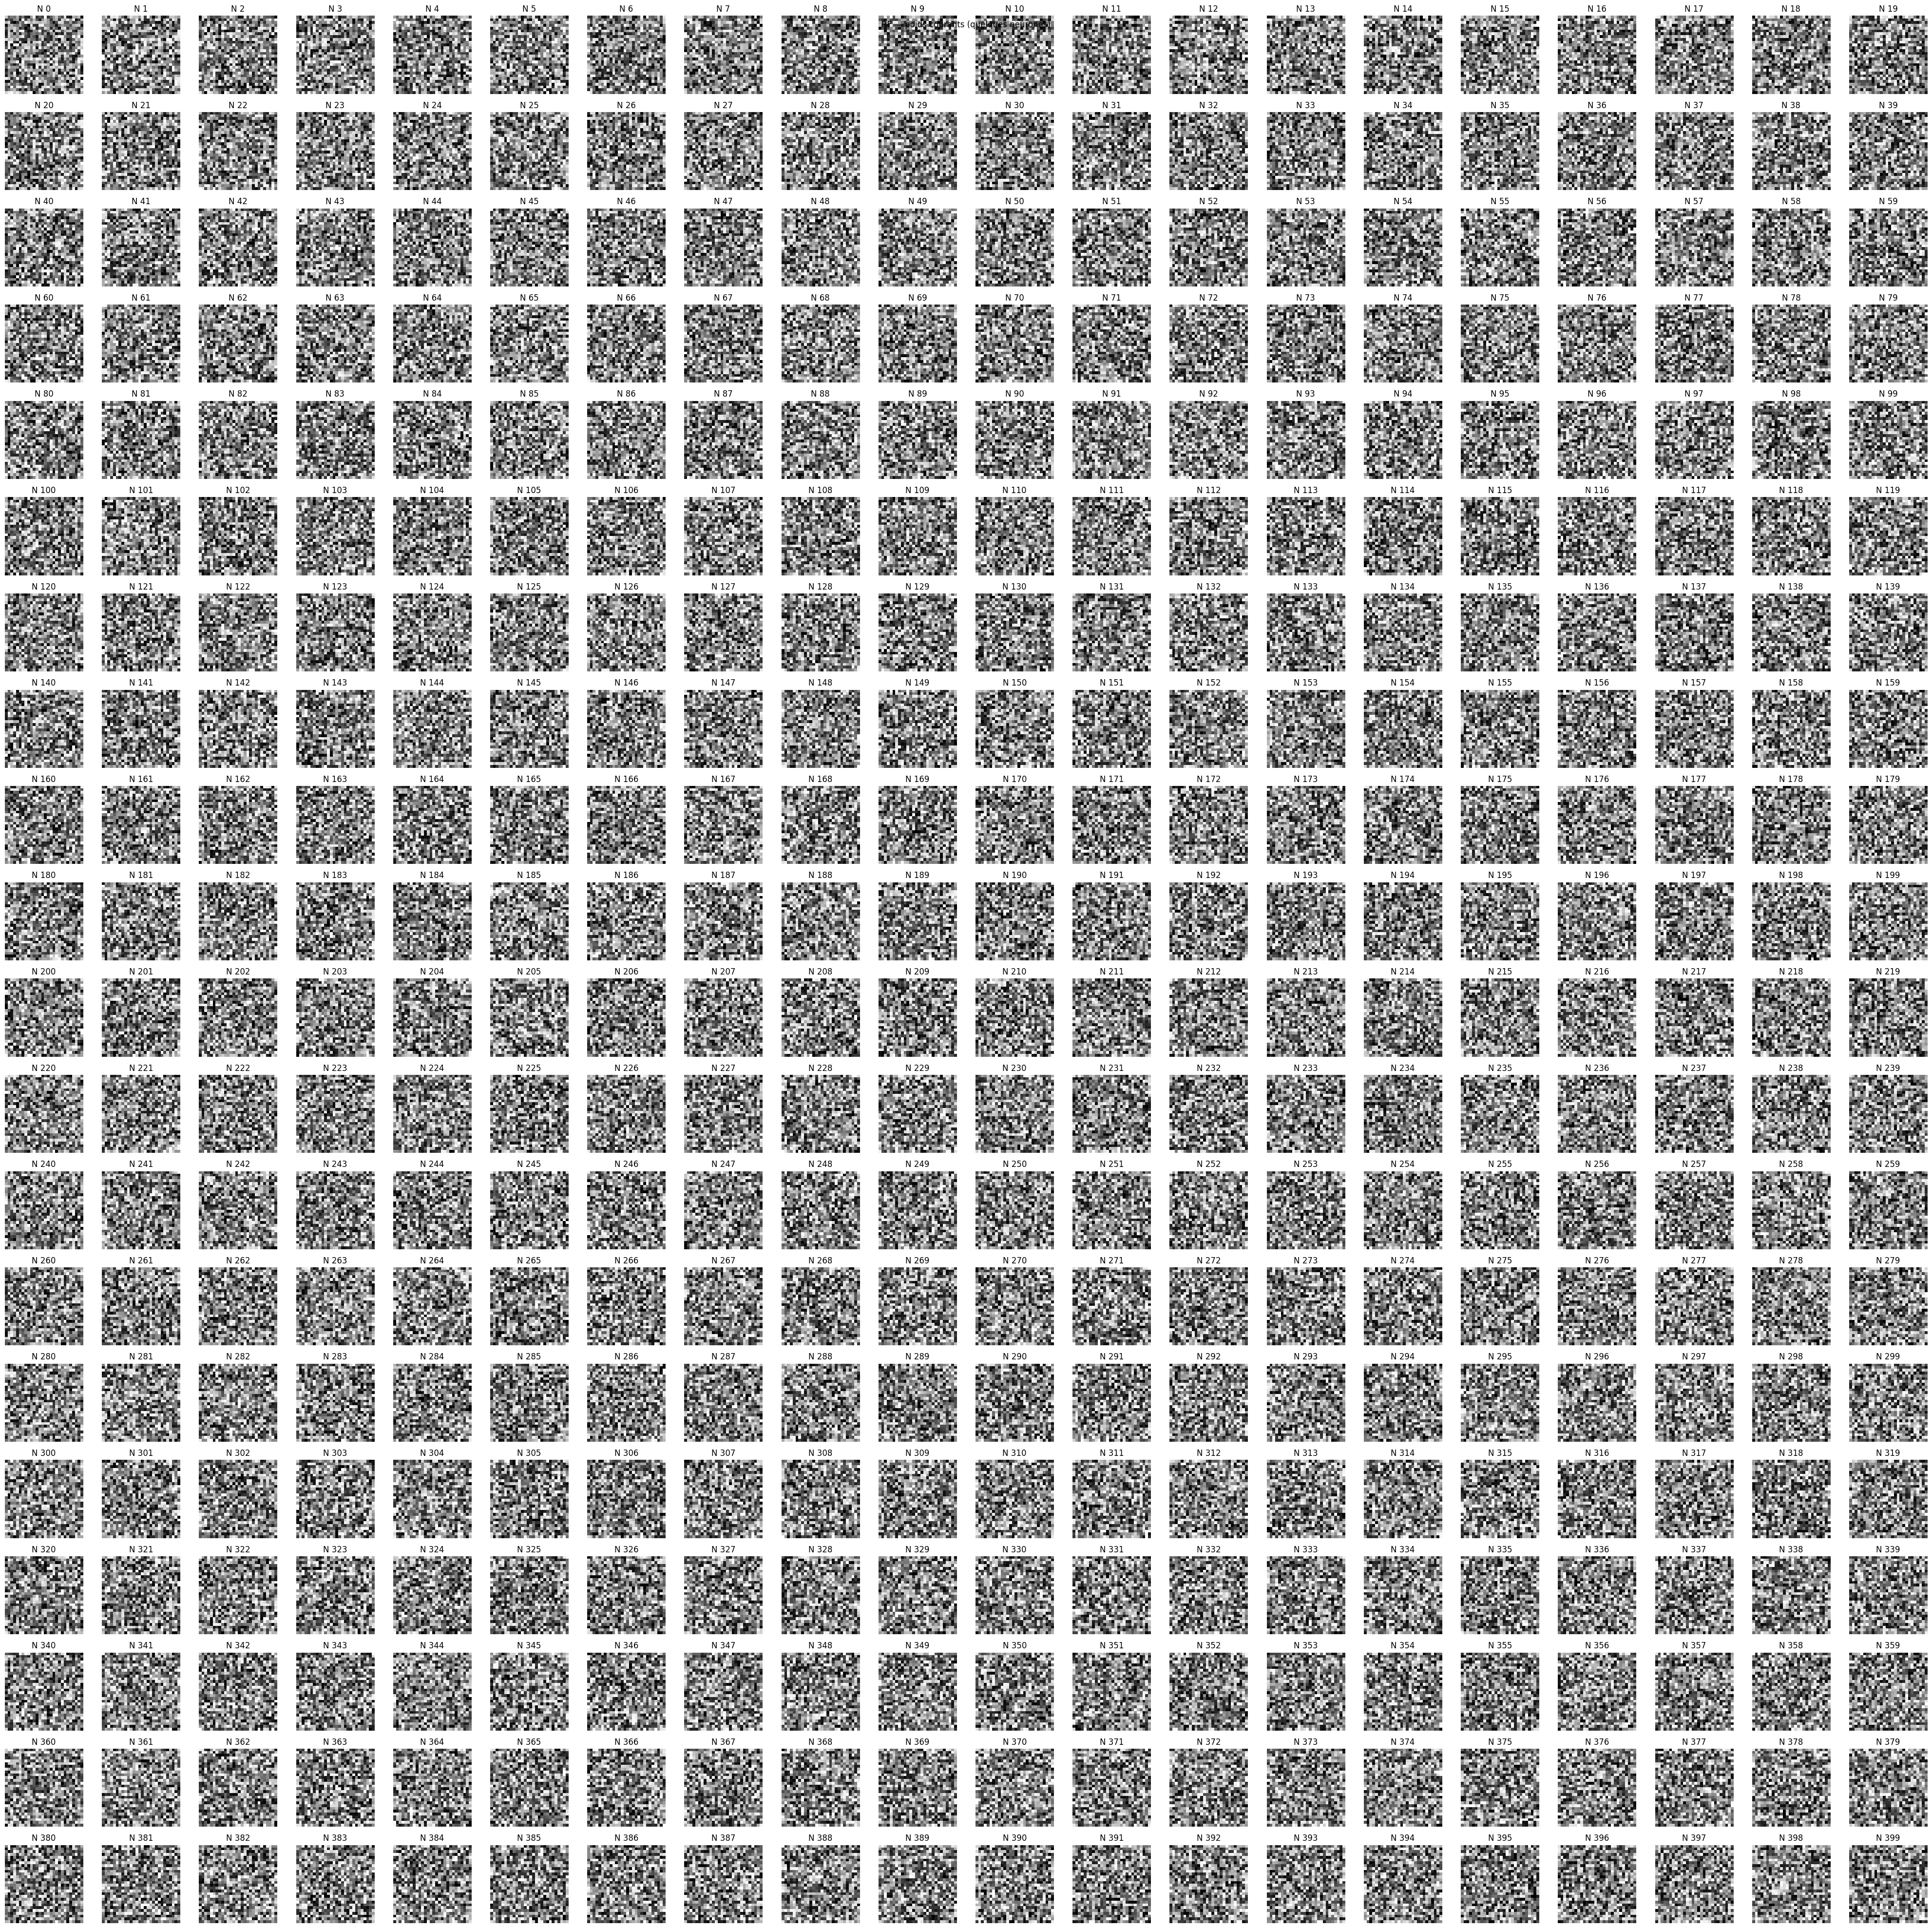

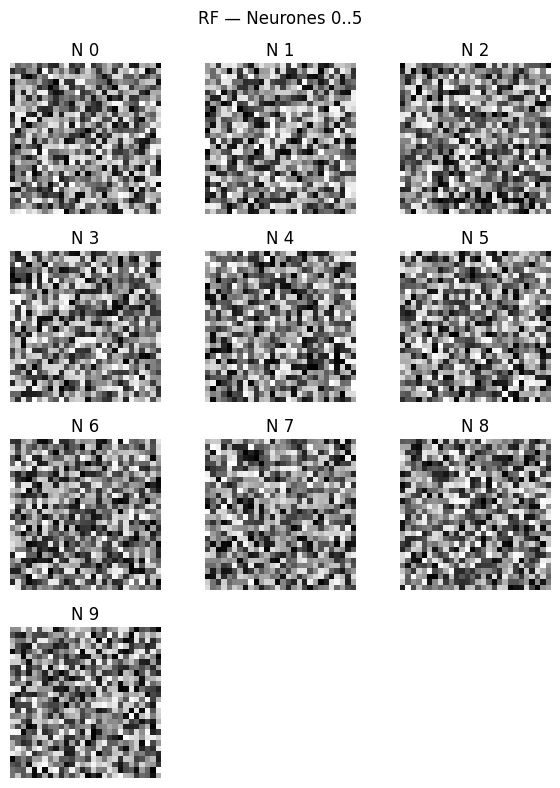

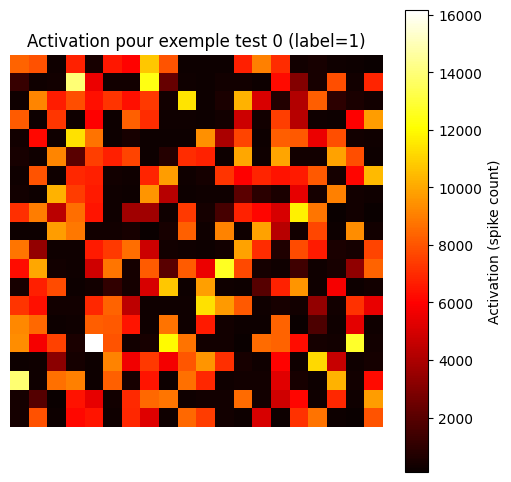

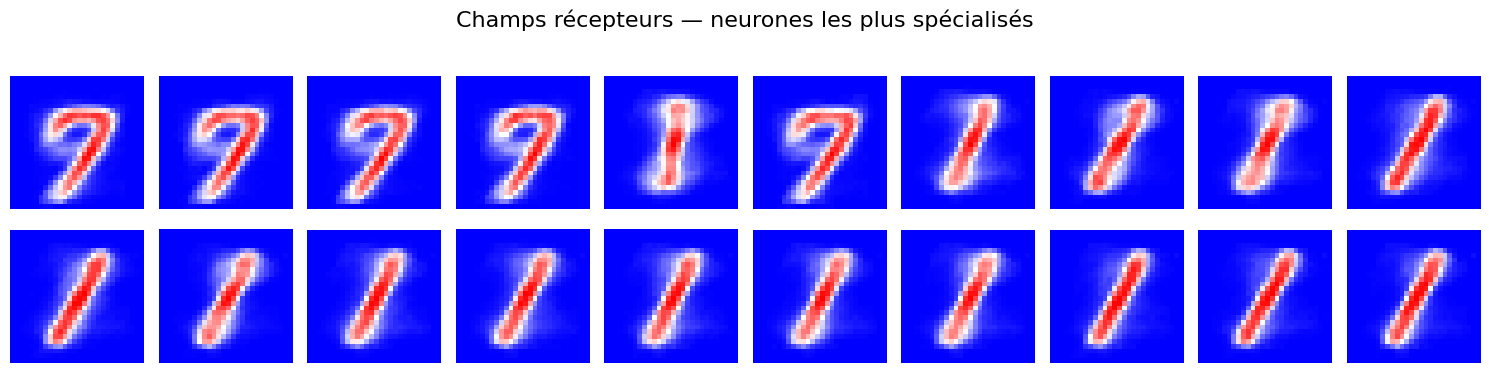

In [106]:
def visualize_receptive_fields(input_synapse, excitatory_group, n_neurons=10):
    weight_matrix = np.zeros((784, len(excitatory_group)))
    weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w

    norms = np.linalg.norm(weight_matrix, axis=0)
    top_neurons = np.argsort(norms)[-n_neurons:]

    plt.figure(figsize=(15, 4))
    for k, neuron_idx in enumerate(top_neurons):
        plt.subplot(2, n_neurons//2, k + 1)
        rf = weight_matrix[:, neuron_idx].reshape(28, 28)
        plt.imshow(rf, cmap='bwr', interpolation='nearest')
        plt.axis('off')

    plt.suptitle("Champs récepteurs — neurones les plus spécialisés", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_receptive_fields(input_synapse, excitatory_group, n_neurons=20)

